# YOLOv3 with Keras


In [12]:
import struct
import pandas as pd 
import random as rd
import time
import matplotlib.pyplot as plt
from matplotlib import patches

import numpy as np 
from numpy import expand_dims
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array

## Create and Save Model

The first step is to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a `DarkNet` and was originally loosely based on the `VGG-16` model.


In [2]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [13]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])   
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

Next, we need to download the pre-trained model weights.

These were trained using the `DarkNet` code base on the <a href="https://cocodataset.org/#home">COCO</a> dataset.

In [14]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

In [15]:
# define the model
model = make_yolov3_model()

# load the model weights and set the model weights into the model
weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)

# save the model to file
model.save('model.hdf5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

the $\texttt{model.hdf5}$ file is saved in my current working directory with approximately the same size as the original weight file (237MB), but ready to be loaded and used directly as a Keras model.

In [1]:
## Make a Prediction

The following list of strings contains the known class labels of the COCO dataset.

In [16]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

Next, we need to load our new photograph and prepare it as suitable input to the model. The model expects inputs to be color images with the square shape of $416\times416$ pixels.

To this end, we use:
* the $\texttt{load_img()}$ Keras function with the $\texttt{target_size}$ argument to resize the image after loading
* and the $\texttt{img_to_array()}$ function to convert the loaded image object into a `NumPy` array.

Also, since we will want to show the original picture again later, we will have to re-scale the future bounding boxes of all detected objects from the square shape to the original shape. Thus, we need to keep the original shape in memory.


In [17]:
def load_image_pixels(filename, shape):
    # load and prepare an image
    img = load_img(filename)  # load the image to get its shape
    width, height = img.size
    img = load_img(filename, target_size=shape)  # load the image with the required size
    img = img_to_array(img)  # convert to numpy array
    img = img.astype('float32')  # scale pixel values to [0, 1]
    img /= 255.0  
    img = expand_dims(img, 0)  # add a dimension so that we have one sample
    return img, width, height

In [18]:
# load yolov3 model
model = load_model('model.hdf5')

In [20]:
input_w, input_h = 416, 416
filename = 'street.jpg'
img, img_w, img_h = load_image_pixels(filename, (input_w, input_h))

# make prediction
yhat = model.predict(img)

print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Running the example returns a list of three `NumPy` arrays. These arrays predict both the bounding boxes and class labels but are encoded.

---
## Make a Prediction and Interpret Result

Following the official <a href="https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg">DarkNet GitHub</a> repository, we will define the anchors as:

In [21]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

In [22]:
import my_yolo3_one_file_to_detect_them_all as yolo3

Any bounding boxes that don’t confidently describe an object (_e.g._ all class probabilities are below a threshold) are ignored. We will use a probability of $60\%$. The function returns a list of $\texttt{BoundBox}$ instances that define the corners of each bounding box in the context of the input image shape and class probabilities.

In [23]:
class_threshold = 0.6  # probability threshold for detected objects
boxes = list()
for i in range(len(yhat)):
    boxes += yolo3.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

In [24]:
yolo3.correct_yolo_boxes(boxes, img_h, img_w, input_h, input_w)

### IoU: Intersection over Union

The model has predicted a lot of candidate bounding boxes, and most of the boxes will be referring to the same objects. The list of bounding boxes can be filtered and those boxes that overlap and refer to the same object can be merged. We can define the amount of overlap as a configuration parameter, in our case, $50\%$. This filtering of bounding box regions is generally referred to as non-maximal suppression and is a required post-processing step.

<br>

Intersection over union (IoU) is known to be a good metric for measuring overlap between two bounding boxes or masks. IoU index is literally calculating the “Area of Intersection” of two boxes over the “Area of Union” of the same two boxes. In object detection IoU is calculated between the ground truth bounding box and the predicted bounding boxes to estimate how close our predicted bounding box is to the ground truth.
* IoU of 1 means the predicted bounding box perfectly matches the ground truth box.
* IoU of 0 means no part of the predicted bounding box overlaps with the ground truth box.

<img src="https://miro.medium.com/max/1400/1*kK0G-BmCqigHrc1rXs7tYQ.jpeg" width="500"/>

<br>

IoU can be used to remove duplicate detections:
1. Pick the bounding box with the largest confidence score and output it as a prediction.
2. Compare this IoU of this bounding box with every other predicted bounding box of the same class, and if the IoU is greater than the user-defined IoU threshold, discard it as it’s duplicate detection.
3. Remove the outputted predicted bounding box from the list of bounding boxes.

<div>
<img src="https://miro.medium.com/max/844/1*9vgYblWTjP0Np7q_PUmlrw.png" width="250" style="display:inline-block;"/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://miro.medium.com/max/1400/1*6d_D0ySg-kOvfrzIRwHIiA.png" width="450" style="display:inline-block;"/>
</div>



In [25]:
# suppress non-maximal boxes
yolo3.do_nms(boxes, 0.5)

This will leave us with the same number of boxes, but only a few of interest. We can retrieve only those boxes that strongly predict the presence of an object, _i.e._ have a confidence of more than $60\%$. To do this, we simply enumerate all the boxes and check the class prediction values. We can then search for the corresponding class label for the box and add it to the list. Each box should be considered for each class label, just in case the same box strongly predicts more than one object.

 $\texttt{get_boxes()}$ is a function that does this by taking the list of boxes, the known labels, and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores.

In [26]:
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:  
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    return v_boxes, v_labels, v_scores

In [27]:
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

bus 75.49901604652405
person 99.3253231048584
truck 67.5427794456482
car 91.33338332176208
car 86.56931519508362
motorbike 99.28786158561707
truck 64.25356864929199
car 91.52400493621826
car 67.67125725746155
car 99.45659637451172


In [28]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # draw all results
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()  # get the context for drawing boxes

    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, fill=False, color='white', linewidth=1.5)
        ax.add_patch(rect)  # draw the box
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])  # draw text and score in top left corner
        plt.text(x1, y1, label, color='white')
    plt.show()

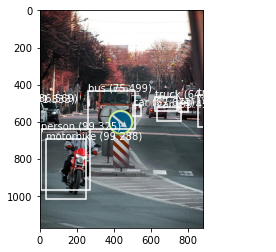

In [29]:
draw_boxes(filename, v_boxes, v_labels, v_scores)

### Testing on a Street Image

<img src="street.jpg" width="300"/> 

bus 75.49901604652405
person 99.3253231048584
truck 67.5427794456482
car 91.33338332176208
car 86.56931519508362
motorbike 99.28786158561707
truck 64.25356864929199
car 91.52400493621826
car 67.67125725746155
car 99.45659637451172


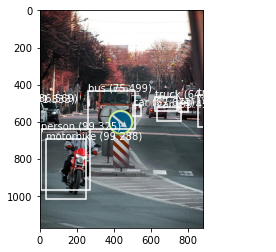

In [31]:
 #load and prepare image
filename = 'street.jpg'
img, img_w, img_h = load_image_pixels(filename, (input_w, input_h))

# make prediction
yhat = model.predict(img)

# create bounding box
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
    boxes += yolo3.decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    
# correct the sizes of the bounding boxes for the shape of the image
yolo3.correct_yolo_boxes(boxes, img_h, img_w, input_h, input_w)

# suppress non-maximal boxes
yolo3.do_nms(boxes, 0.5)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
draw_boxes(filename, v_boxes, v_labels, v_scores)